This is an example notebook to explain important quantities.

In [7]:
#Let us first import the required packages.

%load_ext autoreload
%autoreload 2
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import sys
import importlib
import coffea.util as util
import time
import json
import os
import numba as nb
import awkward.numba

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
#Let us now bring the sample file (a 2018 skimmed signal sample):

sys.path.append("../analysisTools/")
from analysisTools import Analyzer
from analysisTools import loadSchema
import analysisTools as tools
import analysisSubroutines as routines

sample_cfg_dir = "../configs/sample_configs/skimmed_signal/"
histo_cfg_dir = "../configs/histo_configs/"
cut_cfg_dir = "../configs/cut_configs/"

#load the file:
with open(sample_cfg_dir+"skimmed_signal_v9_miniAOD_2018_aEM.json","r") as fin:
    sig_cfg = json.load(fin)

# looking at my favourite entry
sig_cfg[3]

{'location': '/store/group/lpcmetx/iDMe//skimmed_ntuples/signal/signal_v9_miniAOD_2018_aEM_rdfSkim_MET200/output_sig_Mchi-10p5_dMchi-1p0_ct-1/',
 'Mchi': 10.5,
 'dMchi': 1.0,
 'ctau': 1,
 'name': 'sig_Mchi-10.5_dMchi-1.0_ct-1',
 'sum_wgt': 2.4860339635779383e-06,
 'type': 'signal',
 'year': 2018,
 'alphaD': 'aEM',
 'xsec': 40301.1609,
 'nFiles': 1,
 'num_events': 513160,
 'blacklist': []}

In [9]:
#Now, let's make a list of all the `.root` files for this sample. We will use the `XRootD` package to interact with the `eos` filesystem, where the `.root` files are stored.

from XRootD import client
loc = sig_cfg[3]['location']
blacklist = sig_cfg[3]['blacklist']
xrdClient = client.FileSystem("root://cmseos.fnal.gov")
status, flist = xrdClient.dirlist(loc) # get list of files in directory
# select only non-blacklisted root files, prepend the root://cmsxrootd.fnal.gov/ to the file paths
fullList = ["root://cmseos.fnal.gov/"+loc+"/"+item.name for item in flist if (('.root' in item.name) and (item.name not in blacklist))]

fullList

['root://cmseos.fnal.gov//store/group/lpcmetx/iDMe//skimmed_ntuples/signal/signal_v9_miniAOD_2018_aEM_rdfSkim_MET200/output_sig_Mchi-10p5_dMchi-1p0_ct-1//ntuples_sig_Mchi-10.5_dMchi-1.0_ct-1_0.root']

In [10]:
## Using `uproot` to open files

#Now we will use the uproot package to load in a ROOT file and look at its contents. All of the event data is stored in a `TTree` object called `outT` inside the `ntuples` directory of the file.

# open the first file in the list (there is only one file in the list!)

t = uproot.open(fullList[0])['ntuples/outT']
print("\n".join(t.keys()))

APV
year
Electron_passCut
LptElectron_passCut
vtx_isGood
passHEMveto
PFJet_bLoose
PFJet_bMed
PFJet_bTight
anyB_loose
anyB_med
anyB_tight
trigFired
eventNum
lumiSec
runNum
trig_HLT_PFMET90_PFMHT90_IDTight
trig_HLT_PFMET100_PFMHT100_IDTight
trig_HLT_PFMET110_PFMHT110_IDTight
trig_HLT_PFMET120_PFMHT120_IDTight
trig_HLT_PFMET130_PFMHT130_IDTight
trig_HLT_PFMET140_PFMHT140_IDTight
trig_HLT_PFMETTypeOne110_PFMHT110_IDTight
trig_HLT_PFMETTypeOne120_PFMHT120_IDTight
trig_HLT_PFMETTypeOne130_PFMHT130_IDTight
trig_HLT_PFMETTypeOne140_PFMHT140_IDTight
trig_HLT_PFJet15
trig_HLT_PFJet25
trig_HLT_PFJet40
trig_HLT_PFJet60
trig_HLT_PFJet80
trig_HLT_PFJet140
trig_HLT_PFJet200
trig_HLT_PFJet260
trig_HLT_PFJet320
trig_HLT_PFJet400
trig_HLT_PFJet450
trig_HLT_PFJet500
trig_HLT_PFJet550
METFiltersFailBits
nElectron
Electron_pt
Electron_eta
Electron_etaErr
Electron_phi
Electron_phiErr
Electron_IDcutVeto
Electron_IDcutLoose
Electron_IDcutMed
Electron_IDcutTight
Electron_IDcutVetoInt
Electron_IDcutLooseInt
Ele

Now, let us focus on the important quantitites I have discussed before.

In [13]:
#Important quantities:
gen_vxy=t['genEE_vxy'].array()
print (gen_vxy)

gen_dr=t['genEE_dr'].array()
print (gen_dr)

gen_METdphi=t['genEE_METdPhi'].array()
print (gen_METdphi)

gen_pt=t['genEE_pt'].array()
print (gen_pt)

[4.24, 0.526, 1.72, 0.54, 1.96, 0.542, ... 0.485, 1.57, 0.794, 0.845, 0.295, 0.134]
[0.235, 0.0437, 0.0285, 0.0508, 0.199, ... 0.0889, 0.235, 0.145, 0.0442, 0.0873]
[-0.123, -0.0193, -0.027, 0.104, 0.0741, ... 0.0292, -0.176, 0.0952, 0.0277, 0.0787]
[4.79, 16.8, 16.4, 19.8, 7.81, 11.6, 7.08, ... 3.7, 13.2, 2.87, 7.67, 27.8, 15.5]


It's time to plot them using coffea. We use loadNano function from NanoEvents package. 

In [12]:
infile=fullList[0]
events=tools.loadNano(infile)
events.fields


['PFJet',
 'PFMET',
 'Photon',
 'GenJet',
 'Electron',
 'HEM',
 'runNum',
 'nPFJetAll',
 'genEE',
 'passHEMveto',
 'ootPhoton',
 'METFiltersFailBits',
 'genWgt',
 'year',
 'rho',
 'LptElectron',
 'eventNum',
 'trigFired',
 'genPU',
 'signalReconstructed',
 'Conversion',
 'PV',
 'GenPart',
 'GenPos',
 'trig',
 'GenEle',
 'vtx',
 'CaloMET',
 'APV',
 'lumiSec',
 'anyB',
 'GenMET']

[3.88, 4.62, 4.79, 7.34, 3.18, 8.1, 4.4, ... 1.25, 12.3, 0.885, 3.39, 10.4, 10.3]
[0.933, 12.2, 11.6, 12.5, 4.63, 3.5, 2.68, ... 2.47, 0.951, 1.98, 4.28, 17.5, 5.21]
[4.24, 0.526, 1.72, 0.54, 1.96, 0.542, ... 0.485, 1.57, 0.794, 0.845, 0.295, 0.134]
[4.24, 0.526, 1.72, 0.54, 1.96, 0.542, ... 0.485, 1.57, 0.794, 0.845, 0.295, 0.134]


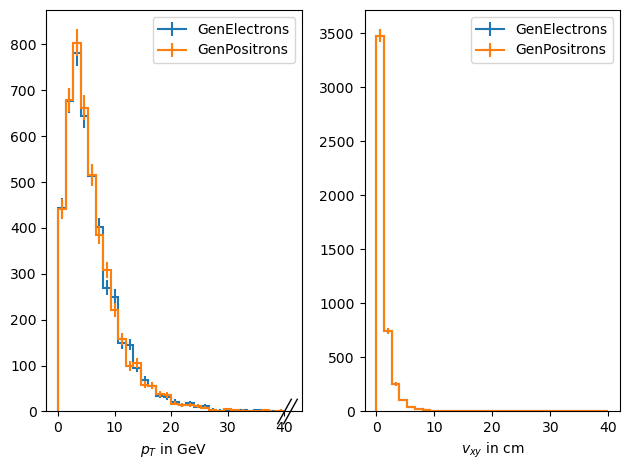

In [16]:
#A very simple histogram for gen electron/ gen positrons:

import hist
from hist import Hist
import numpy as np

#Making a histogram:
plt.subplot(121)   #Focusses on the gen electron/ gen positron pT. 

h_pt = hist.Hist(
    hist.axis.Regular(30,0,40,name="$p_T$ in GeV"), # a "Regular" axis for storing the electron/positron pT
    hist.axis.StrCategory(['GenElectrons','GenPositrons'],name="elepos")
)

gen_ele = events.GenEle.pt
gen_pos = events.GenPos.pt

print (gen_ele)
elemn=np.mean(gen_ele)
print (gen_pos)
elepos=np.mean(gen_pos)

h_pt.fill(gen_ele,elepos = "GenElectrons")
h_pt.fill(gen_pos,elepos = "GenPositrons")
h_pt.plot1d(overlay = 'elepos')
plt.legend()

#Focusses on the gen electron/ gen positron vxy
plt.subplot(122)
h_vxy = hist.Hist(
    hist.axis.Regular(30,0,40,name="$v_{xy}$ in cm"), # a "Regular" axis for storing the electron/positron pT
    hist.axis.StrCategory(['GenElectrons','GenPositrons'],name="elepos")
)

gen_ele = events.GenEle.vxy
gen_pos = events.GenPos.vxy

print (gen_ele)
elemn=np.mean(gen_ele)
print (gen_pos)
elepos=np.mean(gen_pos)

h_vxy.fill(gen_ele,elepos = "GenElectrons")
h_vxy.fill(gen_pos,elepos = "GenPositrons")
h_vxy.plot1d(overlay = 'elepos')   #They overlap in this case
plt.legend()
plt.tight_layout()
plt.savefig("gen pos vs gen ele.png")

[0.235, 0.0437, 0.0285, 0.0508, 0.199, ... 0.0889, 0.235, 0.145, 0.0442, 0.0873]
[-0.123, -0.0193, -0.027, 0.104, 0.0741, ... 0.0292, -0.176, 0.0952, 0.0277, 0.0787]
0.0011640515297734555


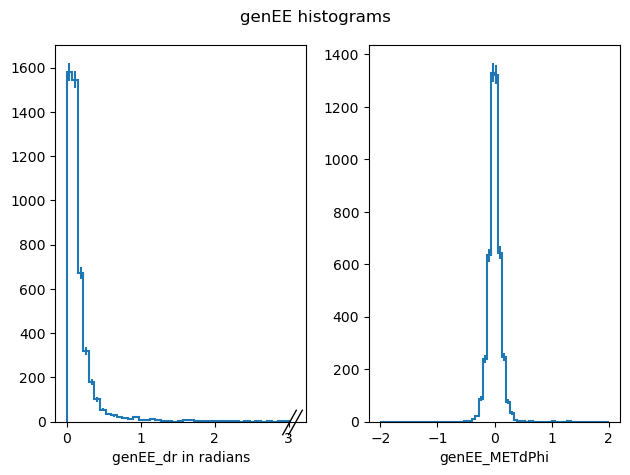

In [17]:
#A very simple histogram:

import hist
from hist import Hist
import numpy as np
import matplotlib.pyplot as plt

plt.suptitle("genEE histograms")

plt.subplot(121)

h_dr = hist.Hist(
hist.axis.Regular(40,0,3,name="genEE_dr in radians"))

gen_DR = events.genEE.dr
print (gen_DR)
mn=np.mean(gen_DR)
h_dr.fill(gen_DR)
h_dr.plot1d()


plt.subplot(122)

h_met = hist.Hist(
    hist.axis.Regular(60,-2,2,name="genEE_METdPhi"))

gen_metdphi = events.genEE.METdPhi


print (gen_metdphi)
mn=np.mean(gen_metdphi)
print (mn)
h_met.fill(gen_metdphi)
h_met.plot1d()

plt.tight_layout()
plt.savefig("genEE")


[4.24, 0.526, 1.72, 0.54, 1.96, 0.542, ... 0.485, 1.57, 0.794, 0.845, 0.295, 0.134]
1.0393433168117343


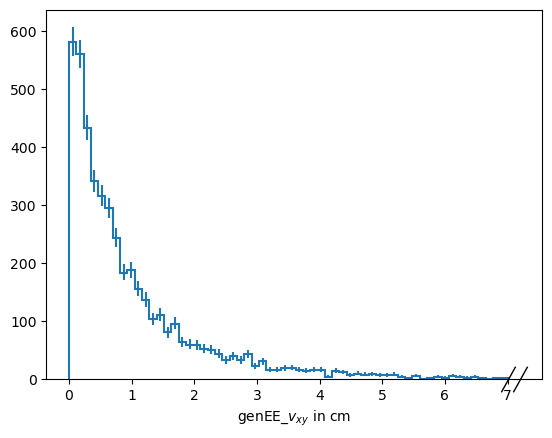

In [18]:
#For genEE_vxy:

import hist
from hist import Hist
import numpy as np

#Making a histogram:
h = hist.Hist(
    hist.axis.Regular(60, 0, 7,name="genEE_$v_{xy}$ in cm")
)

gen_vxy = events.genEE.vxy

print (gen_vxy)
mn = np.mean(gen_vxy)
print (mn)
h.fill(gen_vxy)

h.plot1d()

plt.savefig("eta only")

Since we now know and understand the 3 important quantitites, it is time to compare them using different samples.

Aim: Change the masses of ch1, ch2 and focus on MET dphi, dr and pt plots.

In [29]:
#Samples:

sig_cfg[3]  #sample1

{'location': '/store/group/lpcmetx/iDMe//skimmed_ntuples/signal/signal_v9_miniAOD_2018_aEM_rdfSkim_MET200/output_sig_Mchi-10p5_dMchi-1p0_ct-1/',
 'Mchi': 10.5,
 'dMchi': 1.0,
 'ctau': 1,
 'name': 'sig_Mchi-10.5_dMchi-1.0_ct-1',
 'sum_wgt': 2.4860339635779383e-06,
 'type': 'signal',
 'year': 2018,
 'alphaD': 'aEM',
 'xsec': 40301.1609,
 'nFiles': 1,
 'num_events': 513160,
 'blacklist': []}

In [30]:
sig_cfg[0]   #sample2

{'location': '/store/group/lpcmetx/iDMe//skimmed_ntuples/signal/signal_v9_miniAOD_2018_aEM_rdfSkim_MET200/output_sig_Mchi-105p0_dMchi-10p0_ct-1/',
 'Mchi': 105.0,
 'dMchi': 10.0,
 'ctau': 1,
 'name': 'sig_Mchi-105.0_dMchi-10.0_ct-1',
 'sum_wgt': 2.3678271645621862e-06,
 'type': 'signal',
 'year': 2018,
 'alphaD': 'aEM',
 'xsec': 277.338399693,
 'nFiles': 1,
 'num_events': 78615,
 'blacklist': []}

In [63]:
sig_cfg[12] #sample3

{'location': '/store/group/lpcmetx/iDMe//skimmed_ntuples/signal/signal_v9_miniAOD_2018_aEM_rdfSkim_MET200/output_sig_Mchi-21p0_dMchi-2p0_ct-1/',
 'Mchi': 21.0,
 'dMchi': 2.0,
 'ctau': 1,
 'name': 'sig_Mchi-21.0_dMchi-2.0_ct-1',
 'sum_wgt': 9.511019015917554e-06,
 'type': 'signal',
 'year': 2018,
 'alphaD': 'aEM',
 'xsec': 25833.374,
 'nFiles': 1,
 'num_events': 402997,
 'blacklist': []}

The samples chosen above have varying m1, m2 but constant ctau value. 

In [64]:
#Now, let's make a list of all the `.root` files for this sample. We will use the `XRootD` package to interact with the `eos` filesystem, where the `.root` files are stored.

from XRootD import client

#sample1
loc1 = sig_cfg[3]['location']
blacklist1 = sig_cfg[3]['blacklist']
xrdClient1 = client.FileSystem("root://cmseos.fnal.gov")
status, flist1 = xrdClient1.dirlist(loc1) # get list of files in directory
# select only non-blacklisted root files, prepend the root://cmsxrootd.fnal.gov/ to the file paths
fullList1 = ["root://cmseos.fnal.gov/"+loc1+"/"+item.name for item in flist1 if (('.root' in item.name) and (item.name not in blacklist1))]
fullList1

#sample2
loc2 = sig_cfg[0]['location']
blacklist2 = sig_cfg[0]['blacklist']
xrdClient2 = client.FileSystem("root://cmseos.fnal.gov")
status, flist2 = xrdClient2.dirlist(loc2) # get list of files in directory
# select only non-blacklisted root files, prepend the root://cmsxrootd.fnal.gov/ to the file paths
fullList2 = ["root://cmseos.fnal.gov/"+loc2+"/"+item.name for item in flist2 if (('.root' in item.name) and (item.name not in blacklist2))]
fullList2

#sample3
loc3 = sig_cfg[12]['location']
blacklist3 = sig_cfg[12]['blacklist']
xrdClient3 = client.FileSystem("root://cmseos.fnal.gov")
status, flist3 = xrdClient3.dirlist(loc3) # get list of files in directory
# select only non-blacklisted root files, prepend the root://cmsxrootd.fnal.gov/ to the file paths
fullList3 = ["root://cmseos.fnal.gov/"+loc3+"/"+item.name for item in flist3 if (('.root' in item.name) and (item.name not in blacklist3))]
fullList3

print (fullList1)
print (fullList2)
print (fullList3)

['root://cmseos.fnal.gov//store/group/lpcmetx/iDMe//skimmed_ntuples/signal/signal_v9_miniAOD_2018_aEM_rdfSkim_MET200/output_sig_Mchi-10p5_dMchi-1p0_ct-1//ntuples_sig_Mchi-10.5_dMchi-1.0_ct-1_0.root']
['root://cmseos.fnal.gov//store/group/lpcmetx/iDMe//skimmed_ntuples/signal/signal_v9_miniAOD_2018_aEM_rdfSkim_MET200/output_sig_Mchi-105p0_dMchi-10p0_ct-1//ntuples_sig_Mchi-105.0_dMchi-10.0_ct-1_0.root']
['root://cmseos.fnal.gov//store/group/lpcmetx/iDMe//skimmed_ntuples/signal/signal_v9_miniAOD_2018_aEM_rdfSkim_MET200/output_sig_Mchi-21p0_dMchi-2p0_ct-1//ntuples_sig_Mchi-21.0_dMchi-2.0_ct-1_0.root']


In [65]:
t1 = uproot.open(fullList1[0])['ntuples/outT']
#print("\n".join(t1.keys()))
#print ("...")
t2 = uproot.open(fullList2[0])['ntuples/outT']
#print("\n".join(t2.keys()))

t3 = uproot.open(fullList3[0])['ntuples/outT']
#print("\n".join(t3.keys()))

In [78]:
infile1=fullList1[0]
events1=tools.loadNano(infile1)
print(events1.fields)

infile2=fullList2[0]
events2=tools.loadNano(infile2)
print(events2.fields)

infile3=fullList3[0]
events3=tools.loadNano(infile3)
print(events3.fields)

['PFJet', 'PFMET', 'Photon', 'GenJet', 'Electron', 'HEM', 'runNum', 'nPFJetAll', 'genEE', 'passHEMveto', 'ootPhoton', 'METFiltersFailBits', 'genWgt', 'year', 'rho', 'LptElectron', 'eventNum', 'trigFired', 'genPU', 'signalReconstructed', 'Conversion', 'PV', 'GenPart', 'GenPos', 'trig', 'GenEle', 'vtx', 'CaloMET', 'APV', 'lumiSec', 'anyB', 'GenMET']
['PFJet', 'PFMET', 'Photon', 'GenJet', 'Electron', 'HEM', 'runNum', 'nPFJetAll', 'genEE', 'passHEMveto', 'ootPhoton', 'METFiltersFailBits', 'genWgt', 'year', 'rho', 'LptElectron', 'eventNum', 'trigFired', 'genPU', 'signalReconstructed', 'Conversion', 'PV', 'GenPart', 'GenPos', 'trig', 'GenEle', 'vtx', 'CaloMET', 'APV', 'lumiSec', 'anyB', 'GenMET']
['PFJet', 'PFMET', 'Photon', 'GenJet', 'Electron', 'HEM', 'runNum', 'nPFJetAll', 'genEE', 'passHEMveto', 'ootPhoton', 'METFiltersFailBits', 'genWgt', 'year', 'rho', 'LptElectron', 'eventNum', 'trigFired', 'genPU', 'signalReconstructed', 'Conversion', 'PV', 'GenPart', 'GenPos', 'trig', 'GenEle', 'vtx

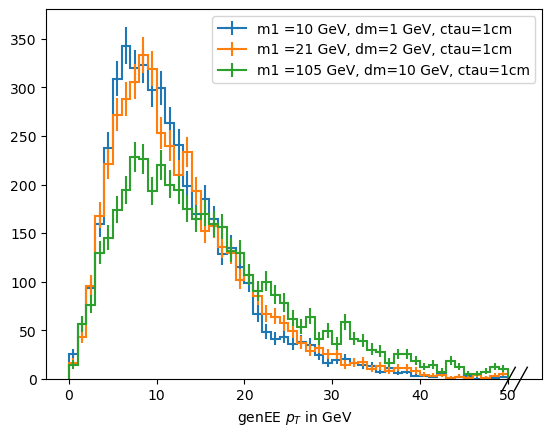

In [103]:
#Histograms for comparison:
import hist
from hist import Hist
import numpy as np

#Making a histogram:

h_pt = hist.Hist(
hist.axis.Regular(50,0,50,name="genEE $p_T$ in GeV"),
hist.axis.StrCategory(['m1 =10 GeV, dm=1 GeV, ctau=1cm','m1 =21 GeV, dm=2 GeV, ctau=1cm','m1 =105 GeV, dm=10 GeV, ctau=1cm'],name="samples")

)

gen_pt1 = events1.genEE.pt
gen_pt2 = events2.genEE.pt
gen_pt3 = events3.genEE.pt

h_pt.fill(gen_pt1, samples='m1 =10 GeV, dm=1 GeV, ctau=1cm')
h_pt.fill(gen_pt3, samples='m1 =21 GeV, dm=2 GeV, ctau=1cm')
h_pt.fill(gen_pt2, samples='m1 =105 GeV, dm=10 GeV, ctau=1cm')

h_pt.plot1d()   
plt.legend()
#hist.axis.StrCategory(['m1 =10GeV, dm=1 GeV'],name="samples")
plt.savefig("3pts")

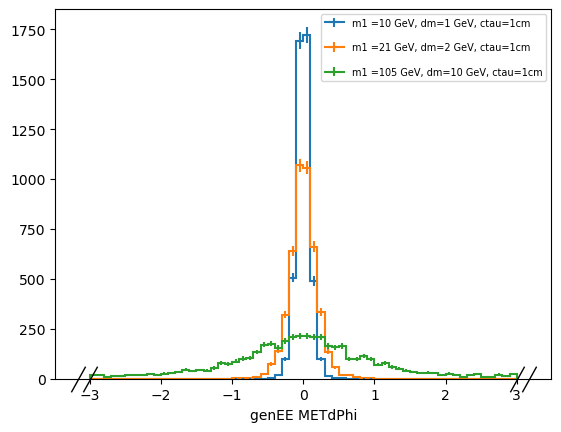

In [116]:
#Histograms for comparison:
import hist
from hist import Hist
import numpy as np

#Making a histogram:

h_mt = hist.Hist(
hist.axis.Regular(60,-3,3,name="genEE METdPhi"),
hist.axis.StrCategory(['m1 =10 GeV, dm=1 GeV, ctau=1cm','m1 =21 GeV, dm=2 GeV, ctau=1cm','m1 =105 GeV, dm=10 GeV, ctau=1cm'],name="samples")

)

gen_mt1 = events1.genEE.METdPhi
gen_mt2 = events2.genEE.METdPhi
gen_mt3 = events3.genEE.METdPhi

h_mt.fill(gen_mt1, samples='m1 =10 GeV, dm=1 GeV, ctau=1cm')
h_mt.fill(gen_mt3, samples='m1 =21 GeV, dm=2 GeV, ctau=1cm')
h_mt.fill(gen_mt2, samples='m1 =105 GeV, dm=10 GeV, ctau=1cm')

h_mt.plot1d()   
plt.legend(loc='upper right',fontsize="7",labelspacing=1.5)
#hist.axis.StrCategory(['m1 =10GeV, dm=1 GeV'],name="samples")
plt.savefig("3mts")